In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import joblib

# Data Loading and Preprocessing

In [2]:
# Data Loading and Preprocessing
def load_tif_files(directory):
    """Load and return a list of arrays representing TIFF files from a directory."""
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = [rasterio.open(fp).read() for fp in tif_files]
    return bands_list

def count_non_nan_pixels(band1, band2):
    """Count the number of non-NaN pixels based on two bands."""
    return np.sum(~np.isnan(band1) & ~np.isnan(band2))

def preprocess_data(non_forest_data, forest_data):
    """Preprocess data to extract features and labels."""
    non_forest_features = np.vstack([extract_features(bands) for bands in non_forest_data])
    forest_features = np.vstack([extract_features(bands) for bands in forest_data])
    
    X = np.vstack([non_forest_features, forest_features])
    y = np.hstack([np.zeros(non_forest_features.shape[0]), np.ones(forest_features.shape[0])])
    
    return X, y

def downsample_data(features, labels, target_class_size=20000):
    """Downsample both classes to the target_class_size, ensuring no NaN values."""
    non_forest_features = features[labels == 0]
    forest_features = features[labels == 1]
    
    non_forest_features = non_forest_features[~np.isnan(non_forest_features).any(axis=1)]
    forest_features = forest_features[~np.isnan(forest_features).any(axis=1)]
    
    np.random.seed(42)
    downsampled_non_forest = non_forest_features[np.random.choice(non_forest_features.shape[0], target_class_size, replace=False)]
    downsampled_forest = forest_features[np.random.choice(forest_features.shape[0], target_class_size, replace=False)]
    
    X_downsampled = np.vstack([downsampled_non_forest, downsampled_forest])
    y_downsampled = np.hstack([np.zeros(downsampled_non_forest.shape[0]), np.ones(downsampled_forest.shape[0])])
    
    return X_downsampled, y_downsampled

### Features selection

In [3]:
# def extract_features(image_data):
#     """Extract features from the first two bands (VV, VH) and the incidence angle."""
#     band1, band2, band3 = image_data
#     return np.vstack([band1.flatten(), band2.flatten(), band3.flatten()]).T

def extract_features(image_data):
    """Extract features from the first two bands (VV, VH) only."""
    band1, band2 = image_data[0], image_data[1]
    return np.vstack([band1.flatten(), band2.flatten()]).T

# def extract_features(image_data):
#     """Extract features from the first two bands (VV, VH) and their ratios to the mean of the incidence angle."""
#     band1, band2, band3 = image_data
    
#     # Calculate the mean of the incidence angle (band3)
#     band3_mean = np.nanmean(band3)
    
#     # Flatten the bands
#     band1_flat = band1.flatten()
#     band2_flat = band2.flatten()
    
#     # Calculate the ratio features
#     band1_ratio = band1_flat / band3_mean
#     band2_ratio = band2_flat / band3_mean
    
#     # Stack the features together
#     features = np.vstack([band1_flat, band2_flat, band1_ratio, band2_ratio]).T
    
#     return features

#### Load Data

In [4]:
target_class_size = 20000

non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)
print(f"Loaded {len(non_forest_data)} non-forest files and {len(forest_data)} forest files.")

# Count and Print Non-NaN Pixels
non_forest_pixel_count = sum(count_non_nan_pixels(bands[0], bands[1]) for bands in non_forest_data)
forest_pixel_count = sum(count_non_nan_pixels(bands[0], bands[1]) for bands in forest_data)
total_pixels = non_forest_pixel_count + forest_pixel_count

print(f"Non-Forest Non-NaN Pixels: {non_forest_pixel_count} ({(non_forest_pixel_count / total_pixels) * 100:.2f}%)")
print(f"Forest Non-NaN Pixels: {forest_pixel_count} ({(forest_pixel_count / total_pixels) * 100:.2f}%)")

# Feature Extraction and Downsampling
X, y = preprocess_data(non_forest_data, forest_data)
X_downsampled, y_downsampled = downsample_data(X, y, target_class_size=target_class_size)

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize Data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

Loaded 31 non-forest files and 45 forest files.
Non-Forest Non-NaN Pixels: 979214 (4.68%)
Forest Non-NaN Pixels: 19928127 (95.32%)
Training set size: 28000 samples
Validation set size: 6000 samples
Test set size: 6000 samples


# Random Forest Classifier

In [5]:
def train_evaluate_rf(X_train, y_train, X_val, y_val):
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    
    rf_val_predictions = rf_classifier.predict(X_val)
    rf_val_accuracy = (rf_val_predictions == y_val).mean()
    print(f"Random Forest Validation Accuracy: {rf_val_accuracy:.4f}")
    
    print("Random Forest Classification Report (Validation Set):")
    print(classification_report(y_val, rf_val_predictions, target_names=['Non-Forest', 'Forest']))
    
    # Plot Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_val, rf_val_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues)
    plt.title("Random Forest Validation Confusion Matrix")
    plt.show()
    
    # Plot Feature Importance
    feature_importances = rf_classifier.feature_importances_
    feature_names = ['Band 1 (VV)', 'Band 2 (VH)', 'Band 1/Incidence Angle - Mean', 'Band 2/Incidence Angle - Mean']  # Update if using only two bands
    indices = np.argsort(feature_importances)[::-1]
    
    plt.figure(figsize=(8, 6))
    plt.title("Feature Importance - Random Forest")
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return rf_classifier


Random Forest Validation Accuracy: 0.7047
Random Forest Classification Report (Validation Set):
              precision    recall  f1-score   support

  Non-Forest       0.71      0.69      0.70      2986
      Forest       0.70      0.72      0.71      3014

    accuracy                           0.70      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.70      0.70      0.70      6000



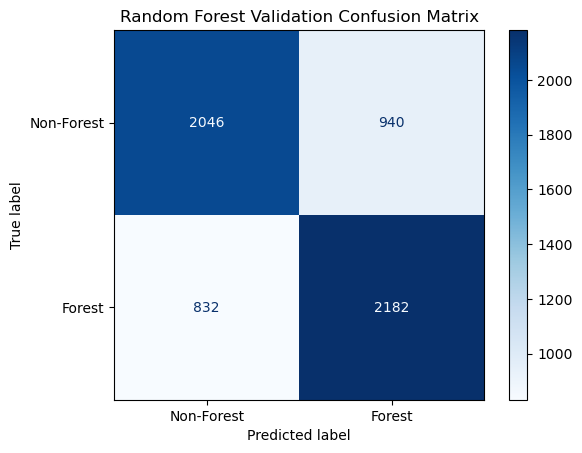

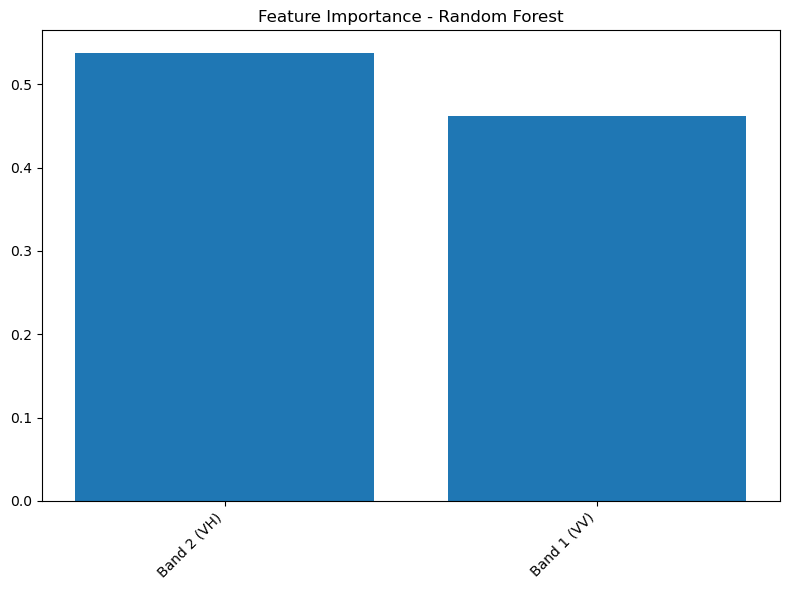

In [6]:
rf_classifier = train_evaluate_rf(X_train_norm, y_train, X_val_norm, y_val)

#### Grid search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

def rf_grid_search(X_train, y_train, X_val, y_val, param_grid):
    """
    Perform a grid search for RandomForestClassifier without cross-validation using F1 score.

    Parameters:
    - X_train: Training feature set.
    - y_train: Training labels.
    - X_val: Validation feature set.
    - y_val: Validation labels.
    - param_grid: Dictionary of hyperparameters to search over.

    Returns:
    - best_params: Dictionary of the best hyperparameters.
    - best_score: Best F1 validation score.
    - best_model: The best trained Random Forest model.
    - feature_importances: Array of feature importances from the best model.
    """

    best_score = 0
    best_params = {}
    best_model = None
    feature_importances = None

    for n_estimators in param_grid.get('n_estimators', [100]):
        for max_depth in param_grid.get('max_depth', [None]):
            for min_samples_split in param_grid.get('min_samples_split', [2]):
                for min_samples_leaf in param_grid.get('min_samples_leaf', [1]):
                    # Define the model with the current parameters
                    rf = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=42
                    )
                    
                    # Train the model
                    rf.fit(X_train, y_train)
                    
                    # Validate the model
                    y_pred = rf.predict(X_val)
                    score = f1_score(y_val, y_pred, average='weighted')  # Calculate weighted F1 score
                    
                    # Check if this is the best score we've seen so far
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf
                        }
                        best_model = rf
                        feature_importances = rf.feature_importances_

    return best_params, best_score, best_model, feature_importances

# Example usage
X_train = X_train_norm 
y_train = y_train  
X_val = X_val_norm    
y_val = y_val    

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_best_params, rf_best_score, rf_best_model, rf_feature_importances = rf_grid_search(X_train, y_train, X_val, y_val, param_grid)

print(f"Best Parameters: {best_params}")
print(f"Best Validation F1 Score: {best_score}")

# Display feature importances
if feature_importances is not None:
    print("Feature Importances:")
    for i, importance in enumerate(feature_importances):
        print(f"Feature {i}: {importance:.4f}")


In [ ]:
rf_classifier = rf_best_model

# SVM Classifier

In [ ]:
def train_evaluate_svm(X_train, y_train, X_val, y_val):
    svm_classifier = SVC(C=1, kernel='rbf', probability=True)
    svm_classifier.fit(X_train, y_train)
    
    svm_val_predictions = svm_classifier.predict(X_val)
    svm_val_accuracy = (svm_val_predictions == y_val).mean()
    print(f"SVM Validation Accuracy: {svm_val_accuracy:.4f}")
    
    print("SVM Classification Report (Validation Set):")
    print(classification_report(y_val, svm_val_predictions, target_names=['Non-Forest', 'Forest']))
    
    ConfusionMatrixDisplay.from_predictions(y_val, svm_val_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues)
    plt.title("SVM Validation Confusion Matrix")
    plt.show()

    return svm_classifier

In [ ]:
svm_classifier = train_evaluate_svm(X_train_norm, y_train, X_val_norm, y_val)

#### Grid search

In [ ]:
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

def svm_grid_search(X_train, y_train, X_val, y_val, param_grid):
    """
    Perform a grid search for SVC without cross-validation using F1 score.

    Parameters:
    - X_train: Training feature set.
    - y_train: Training labels.
    - X_val: Validation feature set.
    - y_val: Validation labels.
    - param_grid: Dictionary of hyperparameters to search over.

    Returns:
    - best_params: Dictionary of the best hyperparameters.
    - best_score: Best F1 validation score.
    - best_model: The best trained SVM model.
    """

    best_score = 0
    best_params = {}
    best_model = None

    for C in param_grid.get('C', [1]):
        for kernel in param_grid.get('kernel', ['rbf']):
            for gamma in param_grid.get('gamma', ['scale']):
                # Define the model with the current parameters
                svm_classifier = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
                svm_classifier.fit(X_train, y_train)
                
                # Validate the model
                svm_val_predictions = svm_classifier.predict(X_val)
                svm_val_f1 = f1_score(y_val, svm_val_predictions, average='weighted')  # Calculate weighted F1 score
                
                # Check if this is the best score we've seen so far
                if svm_val_f1 > best_score:
                    best_score = svm_val_f1
                    best_params = {
                        'C': C,
                        'kernel': kernel,
                        'gamma': gamma
                    }
                    best_model = svm_classifier

    # Evaluate the best model on the validation set
    print(f"Best SVM Validation F1 Score: {best_score:.4f} with parameters: {best_params}")
    print("SVM Classification Report (Validation Set):")
    best_val_predictions = best_model.predict(X_val)
    print(classification_report(y_val, best_val_predictions, target_names=['Non-Forest', 'Forest']))
    
    ConfusionMatrixDisplay.from_predictions(y_val, best_val_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues)
    plt.title("Best SVM Validation Confusion Matrix")
    plt.show()

    return best_model, best_params, best_score

# Example usage
X_train = X_train_norm 
y_train = y_train  
X_val = X_val_norm    
y_val = y_val    

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_best_model, svm_best_params, svm_best_score = svm_grid_search(X_train, y_train, X_val, y_val, param_grid)

print(f"Best Parameters: {best_params}")
print(f"Best Validation F1 Score: {best_score}")


In [ ]:
svm_classifier = svm_best_model

# Model Comparison - Test Data

In [ ]:
def compare_models(rf_classifier, svm_classifier, X_test, y_test):
    rf_test_predictions = rf_classifier.predict(X_test)
    svm_test_predictions = svm_classifier.predict(X_test)
    
    rf_test_accuracy = (rf_test_predictions == y_test).mean()
    svm_test_accuracy = (svm_test_predictions == y_test).mean()
    
    rf_classification_report = classification_report(y_test, rf_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)
    svm_classification_report = classification_report(y_test, svm_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)
    
    metrics_df = pd.DataFrame({
        'Model': ['Random Forest', 'SVM'],
        'Accuracy': [rf_test_accuracy, svm_test_accuracy],
        'Precision (Non-Forest)': [rf_classification_report['Non-Forest']['precision'], svm_classification_report['Non-Forest']['precision']],
        'Recall (Non-Forest)': [rf_classification_report['Non-Forest']['recall'], svm_classification_report['Non-Forest']['recall']],
        'F1-Score (Non-Forest)': [rf_classification_report['Non-Forest']['f1-score'], svm_classification_report['Non-Forest']['f1-score']],
        'Precision (Forest)': [rf_classification_report['Forest']['precision'], svm_classification_report['Forest']['precision']],
        'Recall (Forest)': [rf_classification_report['Forest']['recall'], svm_classification_report['Forest']['recall']],
        'F1-Score (Forest)': [rf_classification_report['Forest']['f1-score'], svm_classification_report['Forest']['f1-score']]
    })
    
    print(metrics_df)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, rf_test_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title("Random Forest Confusion Matrix")
    
    ConfusionMatrixDisplay.from_predictions(y_test, svm_test_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues, ax=axes[1])
    axes[1].set_title("SVM Confusion Matrix")
    
    plt.show()

# Compare Models
compare_models(rf_classifier, svm_classifier, X_test_norm, y_test)

In [ ]:
# Save the SVM Model and Scaler
joblib.dump(rf_classifier, r'D:\Development\RESEARCH\MarvinBlue\Results\rf_model.pkl')
joblib.dump(svm_classifier, r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl')
joblib.dump(scaler, r'D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl')
print("models and scaler saved successfully.")